# **Evaluación de modelo Mistral v2**

Las métricas que se evalúan en este notebook son:

- Accuracy, recall, precision y F1_score con el dataset de validación

- Grado de alucionaciones: se comparan los códigos resueltos por el LLM y se comprueba que sean coherentes (que existan) en la base de datos oficial de ICD10.
  - Se comprueba que existan
  - Se comprueba que sean coherentes: ver similaridad
  - ratio: num_codigos_alucionaciones/num_codigos_response


- Número de entidades reconocidas: se compara el número de entidades de cada nota validadas con el número de entidades reconocida y con el número de entidades que coinciden.

- Ver comparación directa de las entidades

# Librerías

In [ ]:
import pandas as pd
import json
from sklearn.metrics import precision_score, recall_score, f1_score


# Carga de datos

val_data: dataset validado

response_csv: dataset obtenido con LLM

response_json: json obtenido con LLM

response_pe_csv: dataset obtenido con LLM con Prompt Engineering

response_pe_json: json obtenido con LLM con Prompt Engineering

response_CBRAG_csv: dataset obtenido con LLM con RAG con ClinicalBERT

response_CBRAG_json: json obtenido con LLM con RAG con ClinicalBERT

response_BioRAG_csv: dataset obtenido con LLM con RAG con BioBERT

response_BioRAG_json: json obtenido con LLM con RAG con BioBERT

response_BERTRAG_csv: dataset obtenido con LLM con RAG con BERT

response_BERTRAG_json: json obtenido con LLM con RAG con BERT


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar los archivos Mistral raw
val_data = pd.read_csv('/content/drive/MyDrive/Data/Databases/NTT_synthetic_data/150_notes/ntt_synthetic_data_150.csv')
response_csv = pd.read_csv('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_110624_1841.csv')
with open('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_110624_1841.json', 'r') as f:
    response_json = json.load(f)

In [ ]:
# Cargar los archivos Mistral Prompt Engineering
response_pe_csv = pd.read_csv('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_PromptEng_110624_2015.csv')
with open('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_PromptEng_110624_2015.json', 'r') as f:
    response_pe_json = json.load(f)

In [ ]:
# Cargar los archivos Mistral RAG ClinicalBERT
response_CBRAG_csv = pd.read_csv('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_ClinicalBERT_RAG_120624_0924.csv')
with open('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_ClinicalBERT_RAG_120624_0924.json', 'r') as f:
    response_CBRAG_json = json.load(f)

In [ ]:
# Cargar los archivos Mistral RAG BioBERT
response_BioRAG_csv = pd.read_csv('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_BioBERT_RAG_150624_0951.csv')
with open('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_BioBERT_RAG_150624_0951.json', 'r') as f:
    response_BioRAG_json = json.load(f)

In [ ]:
# Cargar los archivos Mistral RAG BERT
response_BERTRAG_csv = pd.read_csv('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_BERT_RAG_250624_1142.csv')
with open('/content/drive/MyDrive/Data/Resultados_Mistral/response_NTT_synthetic_data_150_Mistral_CIE10_BERT_RAG_250624_1142.json', 'r') as f:
    response_BERTRAG_json = json.load(f)

In [ ]:
# Convertir JSON a DataFrame para facilitar la comparación
response_json_df = pd.DataFrame([
    {'id_note': int(key), 'note': value['Note'], 'concepts': value['Concepts']}
    for key, value in response_json.items()
])
response_pe_json_df = pd.DataFrame([
    {'id_note': int(key), 'note': value['Note'], 'concepts': value['Concepts']}
    for key, value in response_pe_json.items()
])
response_CBRAG_json_df = pd.DataFrame([
    {'id_note': int(key), 'note': value['Note'], 'concepts': value['Concepts']}
    for key, value in response_CBRAG_json.items()
])
response_BioRAG_json_df = pd.DataFrame([
    {'id_note': int(key), 'note': value['Note'], 'concepts': value['Concepts']}
    for key, value in response_BioRAG_json.items()
])
response_BERTRAG_json_df = pd.DataFrame([
    {'id_note': int(key), 'note': value['Note'], 'concepts': value['Concepts']}
    for key, value in response_BERTRAG_json.items()
])

# Preprocesamiento de respuestas

In [ ]:
print(f'json de raw mistral: {response_json_df.shape}')
print(f'json de pe mistral: {response_pe_json_df.shape}')
print(f'json de cbrag mistral: {response_CBRAG_json_df.shape}')
print(f'json de biorag mistral: {response_BioRAG_json_df.shape}')
print(f'json de bERTrag mistral: {response_BERTRAG_json_df.shape}')

json de raw mistral: (150, 3)
json de pe mistral: (150, 3)
json de cbrag mistral: (150, 3)
json de biorag mistral: (150, 3)
json de bERTrag mistral: (150, 3)


In [ ]:
val_data.head(2)

,File,Text,ICD10,ICD10Description,Notes
0,1,difficulty in breathing and shortness of breath,R06.02,Breathing difficulty,Pt reports ongoing difficulty in breathing and...
1,1,chronic respiratory failure,J96.1,Chronic respiratory failure,Pt reports ongoing difficulty in breathing and...


In [ ]:
response_csv.head(2)

,id_note,Note,Concept,ICD10
0,3,pt. reports persistent muscl weakness and has ...,"persistent muscle weakness, cramps, and spasms...",M62.81
1,3,pt. reports persistent muscl weakness and has ...,"difficulty speaking, sometimes leading to slur...",R47.1


In [ ]:
print(f'size de val data: \n{val_data.shape}')
print(f'size de raw mistral: \n{response_csv.shape}')
print(f'size de pe mistral: \n{response_pe_csv.shape}')
print(f'size de cbrag mistral: \n{response_CBRAG_csv.shape}')
print(f'size de biorag mistral: \n{response_BioRAG_csv.shape}')
print(f'size de biorag mistral: \n{response_BERTRAG_csv.shape}')

size de val data: 
(1197, 5)
size de raw mistral: 
(974, 4)
size de pe mistral: 
(1108, 4)
size de cbrag mistral: 
(936, 4)
size de biorag mistral: 
(882, 4)
size de biorag mistral: 
(871, 4)


In [ ]:
print(f'Nan de val data: \n{val_data.isna().sum()}')
print(f'Nan de raw mistral: \n{response_csv.isna().sum()}')
print(f'Nan de pe mistral: \n{response_pe_csv.isna().sum()}')
print(f'Nan de cbrag mistral: \n{response_CBRAG_csv.isna().sum()}')
print(f'Nan de biorag mistral: \n{response_BioRAG_csv.isna().sum()}')
print(f'Nan de bERTrag mistral: \n{response_BERTRAG_csv.isna().sum()}')

Nan de val data: 
File                0
Text                0
ICD10               0
ICD10Description    0
Notes               0
dtype: int64
Nan de raw mistral: 
id_note    0
Note       0
Concept    0
ICD10      7
dtype: int64
Nan de pe mistral: 
id_note     0
Note        0
Concept     0
ICD10      12
dtype: int64
Nan de cbrag mistral: 
id_note    0
Note       0
Concept    0
ICD10      7
dtype: int64
Nan de biorag mistral: 
id_note     0
Note        0
Concept     0
ICD10      11
dtype: int64
Nan de bERTrag mistral: 
id_note     0
Note        0
Concept     0
ICD10      11
dtype: int64


In [ ]:
response_csv['ICD10'] = response_csv['ICD10'].fillna('').astype(str)
response_pe_csv['ICD10'] = response_pe_csv['ICD10'].fillna('').astype(str)
response_CBRAG_csv['ICD10'] = response_CBRAG_csv['ICD10'].fillna('').astype(str)
response_BioRAG_csv['ICD10'] = response_BioRAG_csv['ICD10'].fillna('').astype(str)
response_BERTRAG_csv['ICD10'] = response_BERTRAG_csv['ICD10'].fillna('').astype(str)

In [ ]:
def preprocess_responses(response):
  response['Note'] = response['Note'].str.strip('```\n ')
  rows_to_drop_count = 0
  if (response['Concept'] == 'Text').any() or (response['ICD10'] == 'ICD10').any():
    rows_to_drop = response[(response['Concept'] == 'Text') | (response['ICD10'] == 'ICD10')]
    rows_to_drop_count = len(rows_to_drop)
    response.drop(rows_to_drop.index, axis=0, inplace=True)
  return response, rows_to_drop_count

In [ ]:
response_csv, drop_rows = preprocess_responses(response_csv)
print(f"Filas a eliminar: {drop_rows}")
response_csv.head(2)


Filas a eliminar: 0


,id_note,Note,Concept,ICD10
0,3,pt. reports persistent muscl weakness and has ...,"persistent muscle weakness, cramps, and spasms...",M62.81
1,3,pt. reports persistent muscl weakness and has ...,"difficulty speaking, sometimes leading to slur...",R47.1


In [ ]:
response_pe_csv, drop_rows = preprocess_responses(response_pe_csv)
print(f"Filas a eliminar: {drop_rows}")
response_pe_csv.head(2)

Filas a eliminar: 0


,id_note,Note,Concept,ICD10
0,1,pt reports ongoing difficulty in breathing and...,"difficulty in breathing, shortness of breath d...","R06.0, R00.8"
1,1,pt reports ongoing difficulty in breathing and...,"notable increase in muscle weakness, especiall...",M62.81


In [ ]:
response_CBRAG_csv, drop_rows = preprocess_responses(response_CBRAG_csv)
print(f"Filas a eliminar: {drop_rows}")
response_CBRAG_csv.head(2)

Filas a eliminar: 44


,id_note,Note,Concept,ICD10
1,1,pt reports ongoing difficulty in breathing and...,"difficulty in breathing, shortness of breath d...",J46.0
2,1,pt reports ongoing difficulty in breathing and...,"notable increase in muscle weakness, especiall...",M62.81


In [ ]:
response_BioRAG_csv, drop_rows = preprocess_responses(response_BioRAG_csv)
print(f"Filas a eliminar: {drop_rows}")
response_BioRAG_csv.head(2)

Filas a eliminar: 32


,id_note,Note,Concept,ICD10
1,1,pt reports ongoing difficulty in breathing and...,"difficulty in breathing, shortness of breath d...",J46.0
2,1,pt reports ongoing difficulty in breathing and...,"notable increase in muscle weakness, especiall...",M62.81


In [ ]:
response_BERTRAG_csv, drop_rows = preprocess_responses(response_BERTRAG_csv)
print(f"Filas a eliminar: {drop_rows}")
response_BERTRAG_csv.head(2)

Filas a eliminar: 46


,id_note,Note,Concept,ICD10
1,2,patient reports experiencing significant diffi...,"significant difficulty with coordination, part...",R27.0
2,2,patient reports experiencing significant diffi...,"noticeable fasciculation in the left arm, whic...",G26.3


In [ ]:
print(f'Nan de val data: \n{val_data.isna().sum().sum()}')
print(f'Nan de raw mistral: \n{response_csv.isna().sum().sum()}')
print(f'Nan de pe mistral: \n{response_pe_csv.isna().sum().sum()}')
print(f'Nan de cbrag mistral: \n{response_CBRAG_csv.isna().sum().sum()}')
print(f'Nan de biorag mistral: \n{response_BioRAG_csv.isna().sum().sum()}')
print(f'Nan de bERTrag mistral: \n{response_BERTRAG_csv.isna().sum().sum()}')

Nan de val data: 
0
Nan de raw mistral: 
0
Nan de pe mistral: 
0
Nan de cbrag mistral: 
0
Nan de biorag mistral: 
0
Nan de bERTrag mistral: 
0


# Comparación de ICD10 con la base de datos de códigos: Ratio de alucionaciones (códigos inventados)

In [ ]:
official_codes = pd.read_csv('/content/drive/MyDrive/Data/codigos_cie_format.csv')
official_codes.head()

,Code,Description
0,A00.0,"cholera due to vibrio cholerae 01, biovar chol..."
1,A00.1,"cholera due to vibrio cholerae 01, biovar eltor"
2,A00.9,"cholera, unspecified"
3,A01.00,"typhoid fever, unspecified"
4,A01.01,typhoid meningitis


In [ ]:
# para los casos en los que el modelo ha devuelto más de un código para un concepto
def get_descriptions(icd10_codes, official_codes):
    codes = icd10_codes.split(', ')
    descriptions = []
    for code in codes:
        description = official_codes.loc[official_codes['Code'] == code, 'Description']
        if not description.empty:
            descriptions.append(description.values[0])
    return descriptions

In [ ]:
def num_alucionaciones(response, official_codes):
  df_compare_oficd = response[['Concept', 'ICD10']]
  df_compare_oficd = df_compare_oficd.rename(columns={'Concept':'Concept_response'})
  df_compare_oficd['Description_official'] = df_compare_oficd['ICD10'].apply(lambda x: get_descriptions(x, official_codes))
  # df_compare_oficd = df_compare_oficd.merge(official_codes, left_on='ICD10', right_on='Code', how='left')
  # df_compare_oficd.rename(columns={'Description': 'Description_official'}, inplace=True)
  # df_compare_oficd.drop(columns=['Code'], inplace=True)
  num_alucionaciones = df_compare_oficd['Description_official'].apply(lambda x: x == []).sum()
  # num_empty_descriptions = df_compare_oficd_pe['Description_official'].apply(lambda x: len(x) == 0).sum()
  # num_empty_descriptions
  return num_alucionaciones, df_compare_oficd



In [ ]:
num_alu_raw, df_compare_oficd_raw = num_alucionaciones(response_csv, official_codes)
print(f'Raw Mistral response: \n{num_alu_raw}')
print('*'*20)

num_alu_pe, df_compare_oficd_pe = num_alucionaciones(response_pe_csv, official_codes)
print(f'PE Mistral response: \n{num_alu_pe}')
print('*'*20)

num_alu_CBRAG, df_compare_oficd_CBRAG = num_alucionaciones(response_CBRAG_csv, official_codes)
print(f'CBRAG Mistral response: \n{num_alu_CBRAG}')
print('*'*20)

num_alu_BioRAG, df_compare_oficd_BioRAG = num_alucionaciones(response_BioRAG_csv, official_codes)
print(f'BioRAG Mistral response: \n{num_alu_BioRAG}')
print('*'*20)

num_alu_BERTRAG, df_compare_oficd_BERTRAG = num_alucionaciones(response_BERTRAG_csv, official_codes)
print(f'BERTRAG Mistral response: \n{num_alu_BERTRAG}')
print('*'*20)

Raw Mistral response: 
445
********************
PE Mistral response: 
280
********************
CBRAG Mistral response: 
399
********************
BioRAG Mistral response: 
352
********************
BERTRAG Mistral response: 
353
********************


In [ ]:
def ratio_alucionaciones(response, official_codes):
  num, df = num_alucionaciones(response, official_codes)
  response_sz = response.shape[0]
  ratio_alucionaciones = num/response_sz
  return ratio_alucionaciones

print(f'Raw Mistral response: \n{ratio_alucionaciones(response_csv, official_codes)}')

print('*'*20)
print(f'PE Mistral response: \n{ratio_alucionaciones(response_pe_csv, official_codes)}')

print('*'*20)
print(f'CBRAG Mistral response: \n{ratio_alucionaciones(response_CBRAG_csv, official_codes)}')

print('*'*20)
print(f'BioRAG Mistral response: \n{ratio_alucionaciones(response_BioRAG_csv, official_codes)}')

print('*'*20)
print(f'BERTRAG Mistral response: \n{ratio_alucionaciones(response_BERTRAG_csv, official_codes)}')

print('*'*20)

Raw Mistral response: 
0.45687885010266943
********************
PE Mistral response: 
0.2527075812274368
********************
CBRAG Mistral response: 
0.44730941704035876
********************
BioRAG Mistral response: 
0.41411764705882353
********************
BERTRAG Mistral response: 
0.42787878787878786
********************


In [ ]:
df_compare_oficd_pe

,Concept_response,ICD10,Description_official
0,"difficulty in breathing, shortness of breath d...","R06.0, R00.8",[other abnormalities of heart beat]
1,"notable increase in muscle weakness, especiall...",M62.81,[muscle weakness (generalized)]
2,frequent spasms,R25.2,[cramp and spasm]
3,involuntary movements,R25.8,[other abnormal involuntary movements]
4,"dysarthria, affecting pt's ability to communic...",R47.1,[dysarthria and anarthria]
...,...,...,...
1103,frequent dizziness,R42,[dizziness and giddiness]
1104,occasional chest pain,R07.9,"[chest pain, unspecified]"
1105,signs of facial weakness,R29.810,[facial weakness]
1106,"sleep disturbances, likely insomnia",G47.0,[]


In [ ]:
df_compare_oficd_CBRAG

,Concept_response,ICD10,Description_official
1,"difficulty in breathing, shortness of breath d...",J46.0,[]
2,"notable increase in muscle weakness, especiall...",M62.81,[muscle weakness (generalized)]
3,frequent spasms,G26.0,[]
4,involuntary movements,G26.1,[]
5,"dysarthria, affecting pt's ability to communic...",R47.1,[dysarthria and anarthria]
...,...,...,...
931,difficulty swallowing both solids and liquids,R13.1,[]
932,occasional bouts of chest pain,I20.9,"[angina pectoris, unspecified]"
933,signs of facial weakness,G51.2,[melkersson's syndrome]
934,"sleep disturbances, likely insomnia",G47.3,[]


In [ ]:
df_compare_oficd_BioRAG

,Concept_response,ICD10,Description_official
1,"difficulty in breathing, shortness of breath d...",J46.0,[]
2,"notable increase in muscle weakness, especiall...",M62.81,[muscle weakness (generalized)]
3,frequent spasms,G26.0,[]
4,involuntary movements,G25.1,[drug-induced tremor]
5,"dysarthria, affecting pt's ability to communic...",R47.1,[dysarthria and anarthria]
...,...,...,...
877,difficulty swallowing both solids and liquids ...,R13.1,[]
878,occasional bouts of chest pain,I20.9,"[angina pectoris, unspecified]"
879,signs of facial weakness,G51.2,[melkersson's syndrome]
880,persistent numbness and tingling in extremities,R26.0,[ataxic gait]


In [ ]:
df_compare_oficd_BERTRAG

,Concept_response,ICD10,Description_official
1,"significant difficulty with coordination, part...",R27.0,"[ataxia, unspecified]"
2,"noticeable fasciculation in the left arm, whic...",G26.3,[]
3,complains of shortness of breath even during m...,J47.0,[bronchiectasis with acute lower respiratory i...
4,history of depressive episodes and the patient...,F32.9,"[major depressive disorder, single episode, un..."
5,family members report changes in speech fluenc...,R47.1,[dysarthria and anarthria]
...,...,...,...
866,difficulty swallowing both solids and liquids ...,R13.1,[]
867,occasional bouts of chest pain,R02.0,[]
868,signs of facial weakness,I69.292,[facial weakness following other nontraumatic ...
869,"sleep disturbances, likely insomnia",G47.33,[obstructive sleep apnea (adult) (pediatric)]


# Comparación de ICD10 con la base de datos de códigos: SimilarityBERT (códigos mal asignados)

## response_csv (Mistral raw)

In [ ]:
df_compare_oficd_raw

,Concept_response,ICD10,Description_official
0,"persistent muscle weakness, cramps, and spasms...",M62.81,[muscle weakness (generalized)]
1,"difficulty speaking, sometimes leading to slur...",R47.1,[dysarthria and anarthria]
2,feeling light-headed and dizzy often,R54.9,[]
3,difficulty breathing at night,J47.3,[]
4,ongoing issues with urinary incontinence,R35.0,[frequency of micturition]
...,...,...,...
969,frequent dizziness,R42.8,[]
970,occasional bouts of chest pain,I20.9,"[angina pectoris, unspecified]"
971,signs of facial weakness,G51.2,[melkersson's syndrome]
972,"sleep disturbances, likely insomnia",G47.3,[]


### Similaridad con TF-IDF

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# # Asegúrate de que no hay valores nulos en las columnas de texto
# df_compare_oficd['Concept_response'].fillna('', inplace=True)
# df_compare_oficd['Description_official'].fillna('', inplace=True)

# def calculate_similarity(text1, text2):
#     vectorizer = TfidfVectorizer()
#     tfidf_matrix = vectorizer.fit_transform([text1, text2])
#     return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

# # Aplica la función a cada fila del DataFrame
# df_compare_oficd['Similarity'] = df_compare_oficd.apply(lambda row: calculate_similarity(row['Concept_response'], row['Description_official']), axis=1)

# df_compare_oficd


### Similaridad con BERT

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def calculate_similarity_bert(row):
    text1 = row['Concept_response']
    descriptions = row['Description_official']
    if not descriptions or all(pd.isna(descriptions)):
        return 0.0
    max_similarity = 0.0
    embedding1 = get_bert_embedding(text1)
    for text2 in descriptions:
        if text2:
            embedding2 = get_bert_embedding(text2)
            similarity = cosine_similarity(embedding1, embedding2)[0][0]
            if similarity > max_similarity:
                max_similarity = similarity
    return max_similarity

In [ ]:
# Asegúrate de que no hay valores nulos en las columnas de texto
# df_compare_oficd['Concept_response'].fillna('', inplace=True)
# df_compare_oficd['Description_official'].fillna('', inplace=True)

df_compare_oficd_raw['Similarity_BERT'] = df_compare_oficd_raw.apply(calculate_similarity_bert, axis=1)
df_compare_oficd_raw

,Concept_response,ICD10,Description_official,Similarity_BERT
0,"persistent muscle weakness, cramps, and spasms...",M62.81,[muscle weakness (generalized)],0.756937
1,"difficulty speaking, sometimes leading to slur...",R47.1,[dysarthria and anarthria],0.509250
2,feeling light-headed and dizzy often,R54.9,[],0.000000
3,difficulty breathing at night,J47.3,[],0.000000
4,ongoing issues with urinary incontinence,R35.0,[frequency of micturition],0.549506
...,...,...,...,...
969,frequent dizziness,R42.8,[],0.000000
970,occasional bouts of chest pain,I20.9,"[angina pectoris, unspecified]",0.579378
971,signs of facial weakness,G51.2,[melkersson's syndrome],0.658158
972,"sleep disturbances, likely insomnia",G47.3,[],0.000000


In [ ]:
df_compare_oficd_raw['Similarity_BERT'].mean()

0.3586009030499987

In [ ]:
df_compare_oficd_raw[df_compare_oficd_raw['Similarity_BERT'] != 0]['Similarity_BERT'].mean()

0.6602595076950827

## response_pe_csv (Mistral prompt engineering)

In [ ]:
df_compare_oficd_pe['Similarity_BERT'] = df_compare_oficd_pe.apply(calculate_similarity_bert, axis=1)
df_compare_oficd_pe

,Concept_response,ICD10,Description_official,Similarity_BERT
0,"difficulty in breathing, shortness of breath d...","R06.0, R00.8",[other abnormalities of heart beat],0.703923
1,"notable increase in muscle weakness, especiall...",M62.81,[muscle weakness (generalized)],0.809698
2,frequent spasms,R25.2,[cramp and spasm],0.753181
3,involuntary movements,R25.8,[other abnormal involuntary movements],0.820728
4,"dysarthria, affecting pt's ability to communic...",R47.1,[dysarthria and anarthria],0.676659
...,...,...,...,...
1103,frequent dizziness,R42,[dizziness and giddiness],0.761372
1104,occasional chest pain,R07.9,"[chest pain, unspecified]",0.790705
1105,signs of facial weakness,R29.810,[facial weakness],0.827462
1106,"sleep disturbances, likely insomnia",G47.0,[],0.000000


In [ ]:
# def get_descriptions(icd10_codes, official_codes):
#     codes = icd10_codes.split(', ')
#     descriptions = []
#     for code in codes:
#         description = official_codes.loc[official_codes['Code'] == code, 'Description']
#         if not description.empty:
#             descriptions.append(description.values[0])
#     return descriptions

In [ ]:
# df_compare_oficd_pe = response_pe_csv[['Concept', 'ICD10']]
# df_compare_oficd_pe = df_compare_oficd_pe.rename(columns={'Concept':'Concept_response'})
# # df_compare_oficd_pe.fillna('', inplace=True)
# df_compare_oficd_pe['Description_official'] = df_compare_oficd_pe['ICD10'].apply(lambda x: get_descriptions(x, official_codes))


In [ ]:
# num_empty_descriptions = df_compare_oficd_pe['Description_official'].apply(lambda x: len(x) == 0).sum()
# num_empty_descriptions

In [ ]:
df_compare_oficd_pe.isna().sum()

Concept_response        0
ICD10                   0
Description_official    0
Similarity_BERT         0
dtype: int64

In [ ]:
df_compare_oficd_pe['Similarity_BERT'].mean()

0.5463299571607088

In [ ]:
df_compare_oficd_pe[df_compare_oficd_pe['Similarity_BERT'] != 0]['Similarity_BERT'].mean()

0.7310792180363107

## response_CBRAG_csv (Mistral RAG ClinicalBERT)

In [ ]:
df_compare_oficd_CBRAG['Similarity_BERT'] = df_compare_oficd_CBRAG.apply(calculate_similarity_bert, axis=1)
df_compare_oficd_CBRAG

,Concept_response,ICD10,Description_official,Similarity_BERT
1,"difficulty in breathing, shortness of breath d...",J46.0,[],0.000000
2,"notable increase in muscle weakness, especiall...",M62.81,[muscle weakness (generalized)],0.809698
3,frequent spasms,G26.0,[],0.000000
4,involuntary movements,G26.1,[],0.000000
5,"dysarthria, affecting pt's ability to communic...",R47.1,[dysarthria and anarthria],0.676659
...,...,...,...,...
931,difficulty swallowing both solids and liquids,R13.1,[],0.000000
932,occasional bouts of chest pain,I20.9,"[angina pectoris, unspecified]",0.579378
933,signs of facial weakness,G51.2,[melkersson's syndrome],0.658158
934,"sleep disturbances, likely insomnia",G47.3,[],0.000000


In [ ]:
df_compare_oficd_CBRAG['Similarity_BERT'].mean()

0.36553517642176203

In [ ]:
df_compare_oficd_CBRAG[df_compare_oficd_CBRAG['Similarity_BERT'] != 0]['Similarity_BERT'].mean()

0.661373990604892

In [ ]:
# def get_descriptions(icd10_codes, official_codes):
#     codes = icd10_codes.split(', ')
#     descriptions = []
#     for code in codes:
#         description = official_codes.loc[official_codes['Code'] == code, 'Description']
#         if not description.empty:
#             descriptions.append(description.values[0])
#     return descriptions

In [ ]:
# df_compare_oficd_CBRAG = response_CBRAG_csv[['Concept', 'ICD10']]
# df_compare_oficd_CBRAG = df_compare_oficd_CBRAG.rename(columns={'Concept':'Concept_response'})
# df_compare_oficd_CBRAG.fillna('', inplace=True)
# df_compare_oficd_CBRAG['Description_official'] = df_compare_oficd_CBRAG['ICD10'].apply(lambda x: get_descriptions(x, official_codes))


In [ ]:
# num_empty_descriptions = df_compare_oficd_CBRAG['Description_official'].apply(lambda x: len(x) == 0).sum()
# num_empty_descriptions

## response_BioRAG_csv (Mistral RAG BioBERT)

In [ ]:
df_compare_oficd_BioRAG['Similarity_BERT'] = df_compare_oficd_BioRAG.apply(calculate_similarity_bert, axis=1)
df_compare_oficd_BioRAG

,Concept_response,ICD10,Description_official,Similarity_BERT
1,"difficulty in breathing, shortness of breath d...",J46.0,[],0.000000
2,"notable increase in muscle weakness, especiall...",M62.81,[muscle weakness (generalized)],0.809698
3,frequent spasms,G26.0,[],0.000000
4,involuntary movements,G25.1,[drug-induced tremor],0.597349
5,"dysarthria, affecting pt's ability to communic...",R47.1,[dysarthria and anarthria],0.676659
...,...,...,...,...
877,difficulty swallowing both solids and liquids ...,R13.1,[],0.000000
878,occasional bouts of chest pain,I20.9,"[angina pectoris, unspecified]",0.579378
879,signs of facial weakness,G51.2,[melkersson's syndrome],0.658158
880,persistent numbness and tingling in extremities,R26.0,[ataxic gait],0.655700


In [ ]:
df_compare_oficd_BioRAG['Similarity_BERT'].mean()

0.3908708242984379

In [ ]:
df_compare_oficd_BioRAG[df_compare_oficd_BioRAG['Similarity_BERT'] != 0]['Similarity_BERT'].mean()

0.6671489972965305

## response_BERTRAG_csv (Mistral RAG BERT)

In [ ]:
df_compare_oficd_BERTRAG['Similarity_BERT'] = df_compare_oficd_BERTRAG.apply(calculate_similarity_bert, axis=1)
df_compare_oficd_BERTRAG

,Concept_response,ICD10,Description_official,Similarity_BERT
1,"significant difficulty with coordination, part...",R27.0,"[ataxia, unspecified]",0.607706
2,"noticeable fasciculation in the left arm, whic...",G26.3,[],0.000000
3,complains of shortness of breath even during m...,J47.0,[bronchiectasis with acute lower respiratory i...,0.692478
4,history of depressive episodes and the patient...,F32.9,"[major depressive disorder, single episode, un...",0.818300
5,family members report changes in speech fluenc...,R47.1,[dysarthria and anarthria],0.504808
...,...,...,...,...
866,difficulty swallowing both solids and liquids ...,R13.1,[],0.000000
867,occasional bouts of chest pain,R02.0,[],0.000000
868,signs of facial weakness,I69.292,[facial weakness following other nontraumatic ...,0.729332
869,"sleep disturbances, likely insomnia",G47.33,[obstructive sleep apnea (adult) (pediatric)],0.722259


In [ ]:
df_compare_oficd_BERTRAG['Similarity_BERT'].mean()

0.38583035122264514

In [ ]:
df_compare_oficd_BERTRAG[df_compare_oficd_BERTRAG['Similarity_BERT'] != 0]['Similarity_BERT'].mean()

0.6743856774548352

# Comparación con val_data: accuracy, recall, precision, f1

Crea un dataframe combinado de todos los codigos validados frente a los codigos definidos por el LLM

Saca métrica de intersección entre la lista de códigos validados frente a la lista de códigos obtenidos con el LLM

In [ ]:
val_data.head(2)

,File,Concept,ICD10,ICD10Description,Notes
0,1,difficulty in breathing and shortness of breath,R06.02,Breathing difficulty,Pt reports ongoing difficulty in breathing and...
1,1,chronic respiratory failure,J96.1,Chronic respiratory failure,Pt reports ongoing difficulty in breathing and...


In [ ]:
val_data = val_data.rename(columns={'File':'id_note', 'Notes':'Note'})
val_data.head(2)

,id_note,Concept,ICD10,ICD10Description,Note
0,1,difficulty in breathing and shortness of breath,R06.02,Breathing difficulty,Pt reports ongoing difficulty in breathing and...
1,1,chronic respiratory failure,J96.1,Chronic respiratory failure,Pt reports ongoing difficulty in breathing and...


In [ ]:
response_csv.head(2)

,id_note,Note,Concept,ICD10
0,3,pt. reports persistent muscl weakness and has ...,"persistent muscle weakness, cramps, and spasms...",M62.81
1,3,pt. reports persistent muscl weakness and has ...,"difficulty speaking, sometimes leading to slur...",R47.1


## response_csv (Mistral raw)

In [ ]:
def join_icd10_codes(icd10_list):
    if isinstance(icd10_list, list):
        return '; '.join(icd10_list)
    elif pd.notna(icd10_list):  # Manejo de valores NaN
        return str(icd10_list)
    return ''

In [ ]:
def combinar_icdcodes(val_data, response_csv):
  combined_data = []
  val_data_grouped = val_data.groupby('id_note').agg({
      'Note': 'first',
      'ICD10': lambda x: '; '.join(set(x))
  }).reset_index()

  response_csv['ICD10'] = response_csv['ICD10'].apply(join_icd10_codes)
  response_data_grouped = response_csv.groupby('id_note').agg({
      'ICD10': lambda x: '; '.join(set(x))
  }).reset_index()

  for idx, row in val_data_grouped.iterrows():
      id_note = row['id_note']
      note = row['Note']
      val_icd10 = set(row['ICD10'].split('; '))

      response_row = response_data_grouped[response_data_grouped['id_note'] == id_note]
      if not response_row.empty:
          response_icd10 = set(response_row.iloc[0]['ICD10'].split('; '))
      else:
          response_icd10 = set()

      combined_data.append({
          'id_note': id_note,
          'note': note,
          'val_icd10': val_icd10,
          'response_icd10': response_icd10
      })

  combined_df = pd.DataFrame(combined_data)
  return combined_df


In [ ]:
combined_df_raw = combinar_icdcodes(val_data, response_csv)

In [ ]:
combined_df_raw.head(10)

,id_note,note,val_icd10,response_icd10
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....",{}
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{}
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.9}"
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, I10.9, J4..."
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{M62.84, R47.1, R25.2, Z92.3, R53.83, R11.29, ..."
5,6,Pt. c/o persistent muscle weaknes and cramping...,"{M62.81, R47.1, R13.1, R27.8, R25.3, R26.0}",{}
6,7,Patient exhibits severe respiratory distress a...,"{M62.81, J96.1, R13.1, G47.0, R53.83, R06.0}","{M62.81, Z75.5, J96.3, R13.1, J47.3, Z92.3, G1..."
7,8,Pt. complained of persistent numbness and ting...,"{M62.81, J96.1, R47.1, Z99.3, R25.2, R06.0}","{R47.1, R53.82, R35.0, G53.9, J47.3, R59.2, G5..."
8,9,Pt c/o persistent shortness of breath and fati...,"{M62.81, R06.0, F32, F41, R26.0, R43.2}","{M62.84, R29.20, R47.2, R13.2, Z86.019, M55.3,..."
9,10,Pt. presented with severe muscle cramps and fa...,"{M62.81, F41.9, F32.8, R25.3, R06.0, R07.9}","{M62.81, R47.1, R26.3, R25.2, R53.83, H86.0, R..."


In [ ]:
def eval_combined_df(combined_df):
  val_codes = combined_df['val_icd10'].apply(lambda x: list(x))
  response_codes = combined_df['response_icd10'].apply(lambda x: list(x))

  val_codes = [[code.strip() for code in codes] for codes in val_codes]
  response_codes = [[code.strip() for code in codes] for codes in response_codes]

  evaluation_metrics = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1_score': []
  }

  for true_labels, pred_labels in zip(val_codes, response_codes):
      true_set = set(true_labels)
      pred_set = set(pred_labels)
      intersection = true_set.intersection(pred_set)
      union_set = true_set.union(pred_set)

      # Accuracy
      if len(true_set) > 0:
          accuracy = len(intersection) / len(union_set)
      else:
          accuracy = 0

      # Recall
      if len(true_set) > 0:
          recall = len(intersection) / len(true_set)
      else:
          recall = 0

      # Precision
      if len(pred_set) > 0:
          precision = len(intersection) / len(pred_set)
      else:
          precision = 0

      # F1 Score
      if recall + precision > 0:
          f1_score = 2 * (precision * recall) / (precision + recall)
      else:
          f1_score = 0

      evaluation_metrics['accuracy'].append(accuracy)
      evaluation_metrics['recall'].append(recall)
      evaluation_metrics['precision'].append(precision)
      evaluation_metrics['f1_score'].append(f1_score)
  combined_df['accuracy'] = evaluation_metrics['accuracy']
  combined_df['recall'] = evaluation_metrics['recall']
  combined_df['precision'] = evaluation_metrics['precision']
  combined_df['f1_score'] = evaluation_metrics['f1_score']
  return combined_df

In [ ]:
combined_df_raw = eval_combined_df(combined_df_raw)


In [ ]:
print('Métricas de Raw Mistral: \n')
acc_mean = combined_df_raw['accuracy'].mean()
recall_mean = combined_df_raw['recall'].mean()
prec_mean = combined_df_raw['precision'].mean()
f1_mean = combined_df_raw['f1_score'].mean()
print(f'Accuracy = {acc_mean}')
print(f'Recall = {recall_mean}')
print(f'Precision = {prec_mean}')
print(f'F1 = {f1_mean}')

Métricas de Raw Mistral: 

Accuracy = 0.09325244836003349
Recall = 0.15802956302956303
Precision = 0.16207623857623857
F1 = 0.15826179956157072


## response_pe_csv (Mistral prompt engineering)

In [ ]:
combined_df_pe = combinar_icdcodes(val_data, response_pe_csv)
combined_df_pe.shape

(150, 4)

In [ ]:
combined_df_pe.head(10)

,id_note,note,val_icd10,response_icd10
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{M62.81, J96.1, R42, R47.1, I95.1, R25.2, R06...."
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{}
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{R29.2, M62.81, R42, N39.4, R47.1, R25.2, R06.00}"
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R42, R47.81, Z86.011, E11.9, R25.3, R..."
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{F32.A, R47.1, R32, R25.2, R53.83, Z74.0, R06.00}"
5,6,Pt. c/o persistent muscle weaknes and cramping...,"{M62.81, R47.1, R13.1, R27.8, R25.3, R26.0}","{M62.81, Z92.3, Z91.3, R47.1, R53.82, R22.3, R..."
6,7,Patient exhibits severe respiratory distress a...,"{M62.81, J96.1, R13.1, G47.0, R53.83, R06.0}","{, M62.81, J96.9, R13.1, J96.1, R06.0, G47.0, ..."
7,8,Pt. complained of persistent numbness and ting...,"{M62.81, J96.1, R47.1, Z99.3, R25.2, R06.0}","{R29.2, F41.9, R07.9, R06.0, N39.42, R32, R53...."
8,9,Pt c/o persistent shortness of breath and fati...,"{M62.81, R06.0, F32, F41, R26.0, R43.2}","{R47.1, R13.1, R25.2, M62.8, R42.0, R06.0, R53..."
9,10,Pt. presented with severe muscle cramps and fa...,"{M62.81, F41.9, F32.8, R25.3, R06.0, R07.9}",{}


In [ ]:
combined_df_pe = eval_combined_df(combined_df_pe)
combined_df_pe.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{M62.81, J96.1, R42, R47.1, I95.1, R25.2, R06....",0.583333,0.777778,0.700000,0.736842
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{},0.000000,0.000000,0.000000,0.000000
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{R29.2, M62.81, R42, N39.4, R47.1, R25.2, R06.00}",0.176471,0.230769,0.428571,0.300000
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R42, R47.81, Z86.011, E11.9, R25.3, R...",0.062500,0.125000,0.111111,0.117647
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{F32.A, R47.1, R32, R25.2, R53.83, Z74.0, R06.00}",0.200000,0.400000,0.285714,0.333333


In [ ]:
print('Métricas de PE Mistral: \n')
acc_mean = combined_df_pe['accuracy'].mean()
recall_mean = combined_df_pe['recall'].mean()
prec_mean = combined_df_pe['precision'].mean()
f1_mean = combined_df_pe['f1_score'].mean()
print(f'Accuracy = {acc_mean}')
print(f'Recall = {recall_mean}')
print(f'Precision = {prec_mean}')
print(f'F1 = {f1_mean}')

Métricas de PE Mistral: 

Accuracy = 0.33937799401034696
Recall = 0.46882252932252927
Precision = 0.4724819624819624
F1 = 0.46648374075484045


## response_RAG_csv (Mistral RAG Clinical BERT)

In [ ]:
combined_df_CBRAG = combinar_icdcodes(val_data, response_CBRAG_csv)
combined_df_CBRAG.shape

(150, 4)

In [ ]:
combined_df_CBRAG.head(10)

,id_note,note,val_icd10,response_icd10
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{M62.81, R47.1, J47.3, F41.1, J46.0, G26.1, Z9..."
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{}
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{M62.81, R47.1, R35.0, J47.3, R54.1}"
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, F41.1, R4..."
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}",{}
5,6,Pt. c/o persistent muscle weaknes and cramping...,"{M62.81, R47.1, R13.1, R27.8, R25.3, R26.0}","{M62.81, R29.20, R47.1, R13.1, R25.2, R53.83}"
6,7,Patient exhibits severe respiratory distress a...,"{M62.81, J96.1, R13.1, G47.0, R53.83, R06.0}",{}
7,8,Pt. complained of persistent numbness and ting...,"{M62.81, J96.1, R47.1, Z99.3, R25.2, R06.0}","{R53.82, R35.0, G53.9, R47.2, I20.9, J47.31, G..."
8,9,Pt c/o persistent shortness of breath and fati...,"{M62.81, R06.0, F32, F41, R26.0, R43.2}","{M62.84, R29.20, R47.1, R13.1, R25.2, R06.01}"
9,10,Pt. presented with severe muscle cramps and fa...,"{M62.81, F41.9, F32.8, R25.3, R06.0, R07.9}",{}


In [ ]:
combined_df_CBRAG = eval_combined_df(combined_df_CBRAG)
combined_df_CBRAG.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{M62.81, R47.1, J47.3, F41.1, J46.0, G26.1, Z9...",0.117647,0.222222,0.200,0.210526
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{},0.000000,0.000000,0.000,0.000000
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{M62.81, R47.1, R35.0, J47.3, R54.1}",0.058824,0.076923,0.200,0.111111
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, F41.1, R4...",0.066667,0.125000,0.125,0.125000
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}",{},0.000000,0.000000,0.000,0.000000


In [ ]:
print('Métricas de CBRAG Mistral: \n')
acc_mean = combined_df_CBRAG['accuracy'].mean()
recall_mean = combined_df_CBRAG['recall'].mean()
prec_mean = combined_df_CBRAG['precision'].mean()
f1_mean = combined_df_CBRAG['f1_score'].mean()
print(f'Accuracy = {acc_mean}')
print(f'Recall = {recall_mean}')
print(f'Precision = {prec_mean}')
print(f'F1 = {f1_mean}')

Métricas de CBRAG Mistral: 

Accuracy = 0.09162307612694609
Recall = 0.14867852517852517
Precision = 0.16586411736411732
F1 = 0.1547215416710638


## response_BioRAG_csv (Mistral RAG BioBERT)

In [ ]:
combined_df_BioRAG = combinar_icdcodes(val_data, response_BioRAG_csv)
combined_df_BioRAG.shape

(150, 4)

In [ ]:
combined_df_BioRAG.head(10)

,id_note,note,val_icd10,response_icd10
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{G25.1, M62.81, R47.1, J47.3, J46.0, F41.1, Z9..."
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{}
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.1}"
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R29.20, R47.1, R13.1, G11.2, R26.3, Z..."
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{R47.1, M62.81, G83.1, R25.2, R53.83, F32.0, R..."
5,6,Pt. c/o persistent muscle weaknes and cramping...,"{M62.81, R47.1, R13.1, R27.8, R25.3, R26.0}","{M62.81, R29.20, R47.1, R25.2, R53.83, R13.2}"
6,7,Patient exhibits severe respiratory distress a...,"{M62.81, J96.1, R13.1, G47.0, R53.83, R06.0}",{}
7,8,Pt. complained of persistent numbness and ting...,"{M62.81, J96.1, R47.1, Z99.3, R25.2, R06.0}","{G51.1, R47.1, R35.0, G53.9, J47.3, R25.2, R53..."
8,9,Pt c/o persistent shortness of breath and fati...,"{M62.81, R06.0, F32, F41, R26.0, R43.2}",{}
9,10,Pt. presented with severe muscle cramps and fa...,"{M62.81, F41.9, F32.8, R25.3, R06.0, R07.9}",{}


In [ ]:
combined_df_BioRAG = eval_combined_df(combined_df_BioRAG)
combined_df_BioRAG.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{G25.1, M62.81, R47.1, J47.3, J46.0, F41.1, Z9...",0.117647,0.222222,0.200000,0.210526
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{},0.000000,0.000000,0.000000,0.000000
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.1}",0.055556,0.076923,0.166667,0.105263
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R29.20, R47.1, R13.1, G11.2, R26.3, Z...",0.066667,0.125000,0.125000,0.125000
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{R47.1, M62.81, G83.1, R25.2, R53.83, F32.0, R...",0.083333,0.200000,0.125000,0.153846


In [ ]:
print('Métricas de BioRAG Mistral: \n')
acc_mean = combined_df_BioRAG['accuracy'].mean()
recall_mean = combined_df_BioRAG['recall'].mean()
prec_mean = combined_df_BioRAG['precision'].mean()
f1_mean = combined_df_BioRAG['f1_score'].mean()
print(f'Accuracy = {acc_mean}')
print(f'Recall = {recall_mean}')
print(f'Precision = {prec_mean}')
print(f'F1 = {f1_mean}')

Métricas de BioRAG Mistral: 

Accuracy = 0.10285144347683048
Recall = 0.1692098642098642
Precision = 0.18417219817219815
F1 = 0.17443978009148287


## response_BERTRAG_csv (Mistral RAG BERT)

In [ ]:
combined_df_BERTRAG = combinar_icdcodes(val_data, response_BERTRAG_csv)
combined_df_BERTRAG.shape

(150, 4)

In [ ]:
combined_df_BERTRAG.head(10)

,id_note,note,val_icd10,response_icd10
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....",{}
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....","{F32.9, R27.0, G26.3, R47.1, J47.0}"
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.9}"
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, Z92.2, R4..."
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}",{}
5,6,Pt. c/o persistent muscle weaknes and cramping...,"{M62.81, R47.1, R13.1, R27.8, R25.3, R26.0}",{}
6,7,Patient exhibits severe respiratory distress a...,"{M62.81, J96.1, R13.1, G47.0, R53.83, R06.0}",{}
7,8,Pt. complained of persistent numbness and ting...,"{M62.81, J96.1, R47.1, Z99.3, R25.2, R06.0}","{R47.1, R35.0, J47.3, R25.2, R53.83, I20.9, G5..."
8,9,Pt c/o persistent shortness of breath and fati...,"{M62.81, R06.0, F32, F41, R26.0, R43.2}","{R10.30, M62.84, R47.2, R56.0, R13.2, M55.3}"
9,10,Pt. presented with severe muscle cramps and fa...,"{M62.81, F41.9, F32.8, R25.3, R06.0, R07.9}",{}


In [ ]:
combined_df_BERTRAG = eval_combined_df(combined_df_BERTRAG)
combined_df_BERTRAG.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....",{},0.000000,0.000000,0.000000,0.000000
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....","{F32.9, R27.0, G26.3, R47.1, J47.0}",0.000000,0.000000,0.000000,0.000000
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.9}",0.055556,0.076923,0.166667,0.105263
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, Z92.2, R4...",0.066667,0.125000,0.125000,0.125000
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}",{},0.000000,0.000000,0.000000,0.000000


In [ ]:
print('Métricas de BioRAG Mistral: \n')
acc_mean = combined_df_BERTRAG['accuracy'].mean()
recall_mean = combined_df_BERTRAG['recall'].mean()
prec_mean = combined_df_BERTRAG['precision'].mean()
f1_mean = combined_df_BERTRAG['f1_score'].mean()
print(f'Accuracy = {acc_mean}')
print(f'Recall = {recall_mean}')
print(f'Precision = {prec_mean}')
print(f'F1 = {f1_mean}')

Métricas de BioRAG Mistral: 

Accuracy = 0.0972742790691707
Recall = 0.15667025567025566
Precision = 0.17556227106227104
F1 = 0.1634763171698156


# Comparación de número de entidades reconocidas

In [ ]:
val_data= val_data.rename(columns={'Text':'Concept'})

In [ ]:
def num_entities(val_data, response_csv, df_icdgrouped):
  val_concepts_grouped = val_data.groupby('id_note').agg({
      'Concept': 'count',
  }).reset_index().rename(columns={'Concept': 'num_val_concepts'})

  response_concepts_grouped = response_csv.groupby('id_note').agg({
      'Concept': 'count',
  }).reset_index().rename(columns={'Concept': 'num_response_concepts'})

  combined_df = pd.merge(df_icdgrouped, val_concepts_grouped[['id_note', 'num_val_concepts']], on='id_note', how='left')
  combined_df = pd.merge(combined_df, response_concepts_grouped[['id_note', 'num_response_concepts']], on='id_note', how='left')
  combined_df.fillna(0, inplace=True)
  return combined_df

## response_csv (Mistral raw)

In [ ]:
combined_df_raw_entities = num_entities(val_data, response_csv, combined_df_raw)
combined_df_raw_entities.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score,num_val_concepts,num_response_concepts
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....",{},0.000000,0.000000,0.000000,0.000000,9,0.0
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{},0.000000,0.000000,0.000000,0.000000,9,0.0
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.9}",0.055556,0.076923,0.166667,0.105263,13,6.0
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, I10.9, J4...",0.058824,0.125000,0.100000,0.111111,8,10.0
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{M62.84, R47.1, R25.2, Z92.3, R53.83, R11.29, ...",0.090909,0.200000,0.142857,0.166667,6,7.0


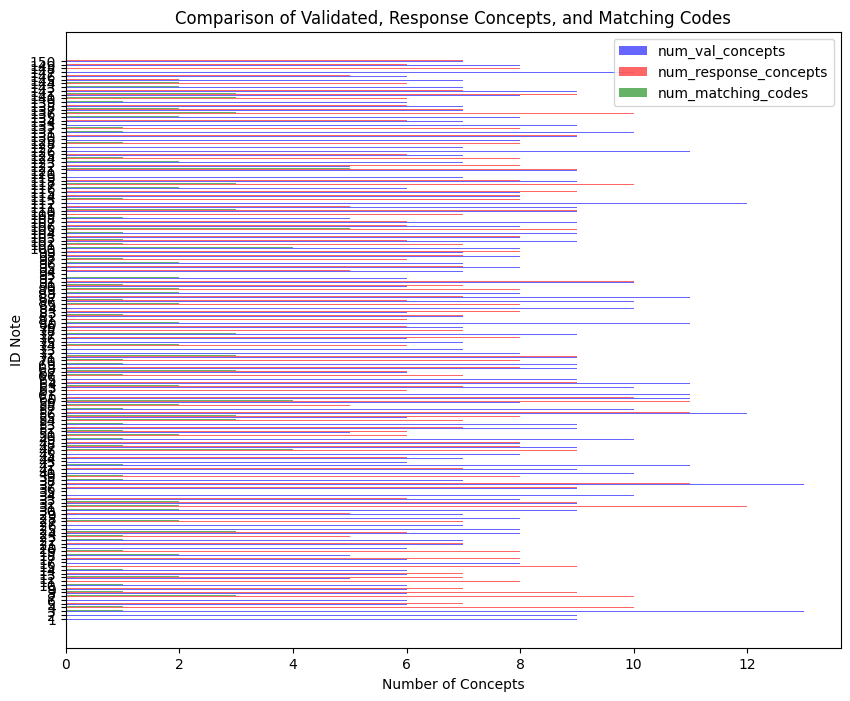

In [ ]:
import matplotlib.pyplot as plt
def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_raw_entities['num_matching_codes'] = combined_df_raw_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = combined_df_raw_entities['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, combined_df_raw_entities['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='num_val_concepts')
bars2 = ax.barh(r2, combined_df_raw_entities['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='num_response_concepts')
bars3 = ax.barh(r3, combined_df_raw_entities['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='num_matching_codes')

# Añadir etiquetas y título
ax.set_ylabel('ID Note')
ax.set_xlabel('Number of Concepts')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes')
ax.set_yticks(y)
ax.set_yticklabels(combined_df_raw_entities['id_note'])
ax.legend()

# Añadir los valores de 'evaluation_metric' al lado derecho de las barras
# for i, (r1_val, r2_val, r3_val, eval_metric) in enumerate(zip(r1, r2, r3, combined_df['evaluation_metric'])):
#     ax.text(combined_df['num_response_concepts'][i] + 0.1, r2_val, f'{eval_metric:.2f}', va='center')

# Mostrar el gráfico
plt.show()

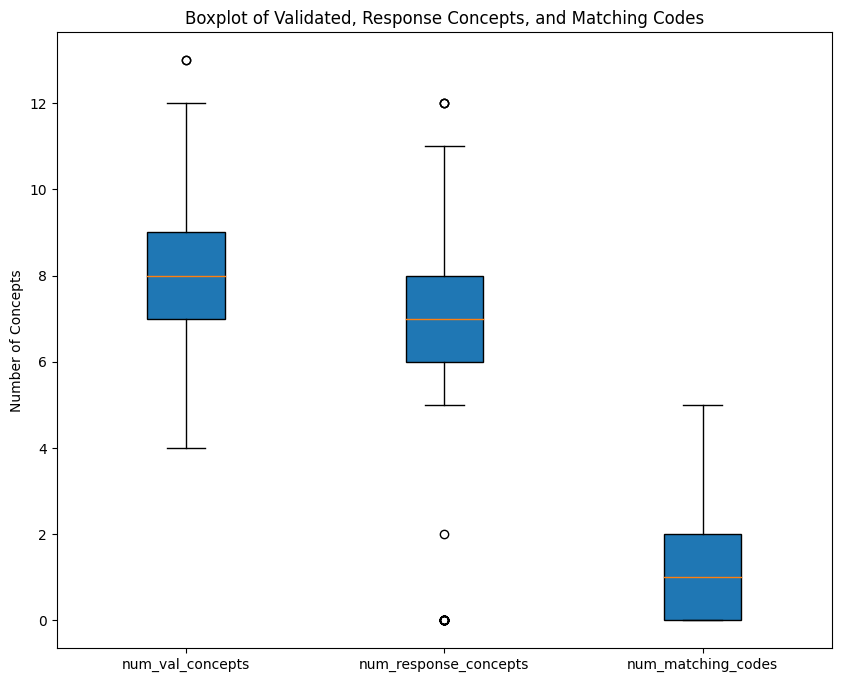

In [ ]:
import matplotlib.pyplot as plt

# Crear el boxplot para las columnas especificadas
fig, ax = plt.subplots(figsize=(10, 8))

# Datos para el boxplot
data = [
    combined_df_raw_entities['num_val_concepts'],
    combined_df_raw_entities['num_response_concepts'],
    combined_df_raw_entities['num_matching_codes']
]

# Crear el boxplot
ax.boxplot(data, patch_artist=True, vert=True, labels=['num_val_concepts', 'num_response_concepts', 'num_matching_codes'])

# Añadir etiquetas y título
ax.set_ylabel('Number of Concepts')
ax.set_title('Boxplot of Validated, Response Concepts, and Matching Codes')

# Mostrar el gráfico
plt.show()


In [ ]:
combined_df_raw_entities['difference'] = (combined_df_raw_entities['num_val_concepts'] - combined_df_raw_entities['num_response_concepts']).abs()

# Calcular la media de estas diferencias
mean_difference_raw = combined_df_raw_entities['difference'].mean()

print("La diferencia media es:", round(mean_difference_raw))

La diferencia media es: 2


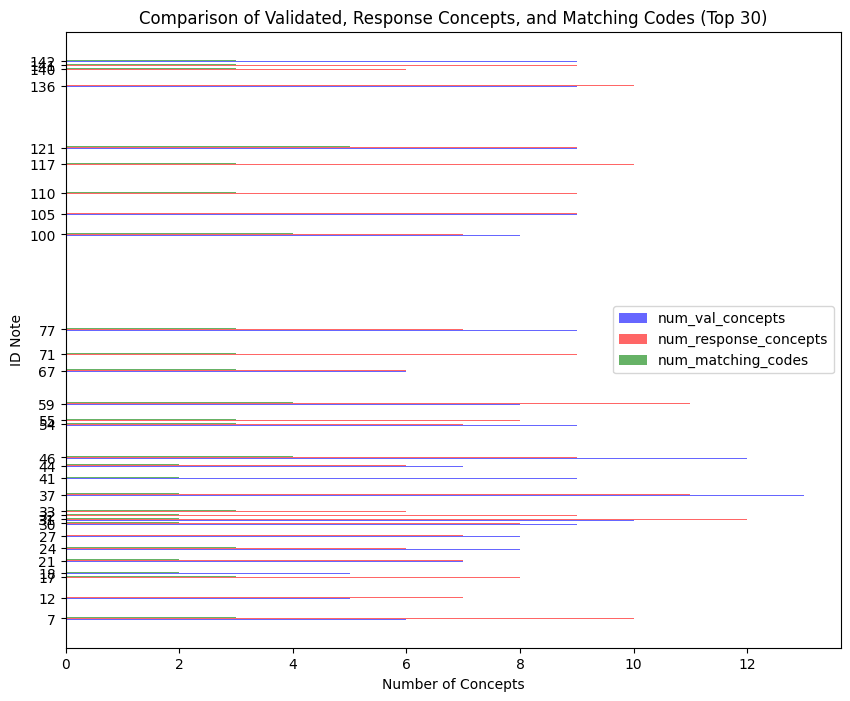

In [ ]:
import matplotlib.pyplot as plt

def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_raw_entities['num_matching_codes'] = combined_df_raw_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Ordenar el DataFrame por 'num_matching_codes' en orden descendente y tomar los primeros 30
top_30_df = combined_df_raw_entities.nlargest(30, 'num_matching_codes')

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = top_30_df['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, top_30_df['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='num_val_concepts')
bars2 = ax.barh(r2, top_30_df['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='num_response_concepts')
bars3 = ax.barh(r3, top_30_df['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='num_matching_codes')

# Añadir etiquetas y título
ax.set_ylabel('ID Note')
ax.set_xlabel('Number of Concepts')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes (Top 30)')
ax.set_yticks(y)
ax.set_yticklabels(top_30_df['id_note'])
ax.legend()

# Mostrar el gráfico
plt.show()


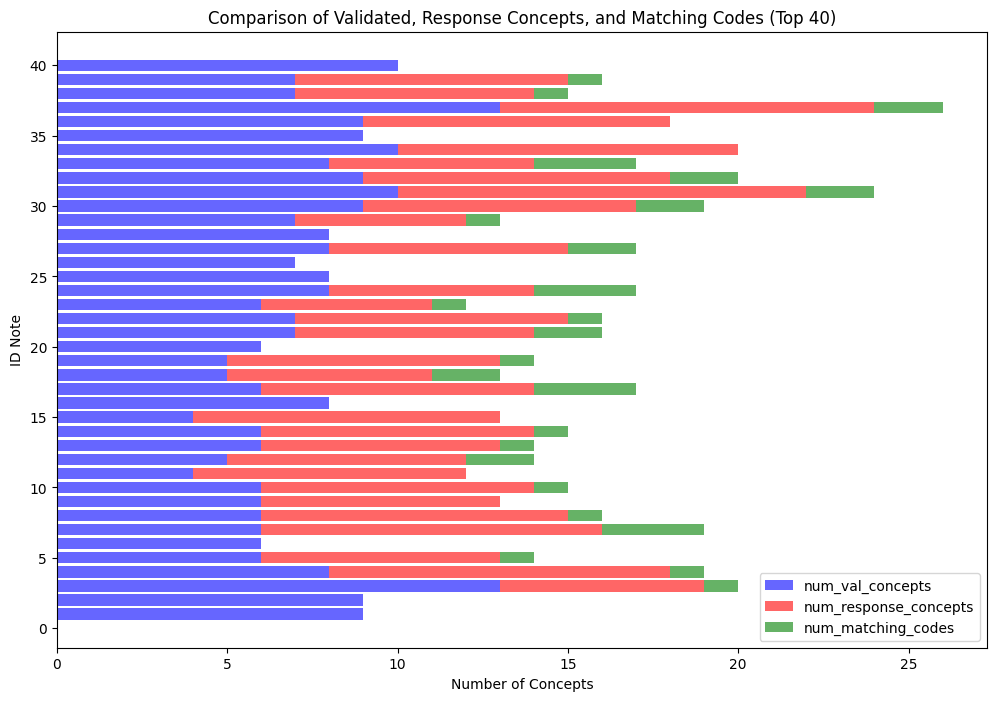

In [ ]:
import matplotlib.pyplot as plt

# Seleccionar los primeros 40 registros
top_40_df = combined_df_raw_entities.head(40)

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(12, 8))

# Crear las barras apiladas
ax.barh(top_40_df['id_note'], top_40_df['num_val_concepts'], color='b', alpha=0.6, label='num_val_concepts')
ax.barh(top_40_df['id_note'], top_40_df['num_response_concepts'], color='r', alpha=0.6, label='num_response_concepts', left=top_40_df['num_val_concepts'])
ax.barh(top_40_df['id_note'], top_40_df['num_matching_codes'], color='g', alpha=0.6, label='num_matching_codes', left=top_40_df['num_val_concepts'] + top_40_df['num_response_concepts'])

# Añadir etiquetas y título
ax.set_ylabel('ID Note')
ax.set_xlabel('Number of Concepts')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes (Top 40)')
ax.legend()

# Mostrar el gráfico
plt.show()


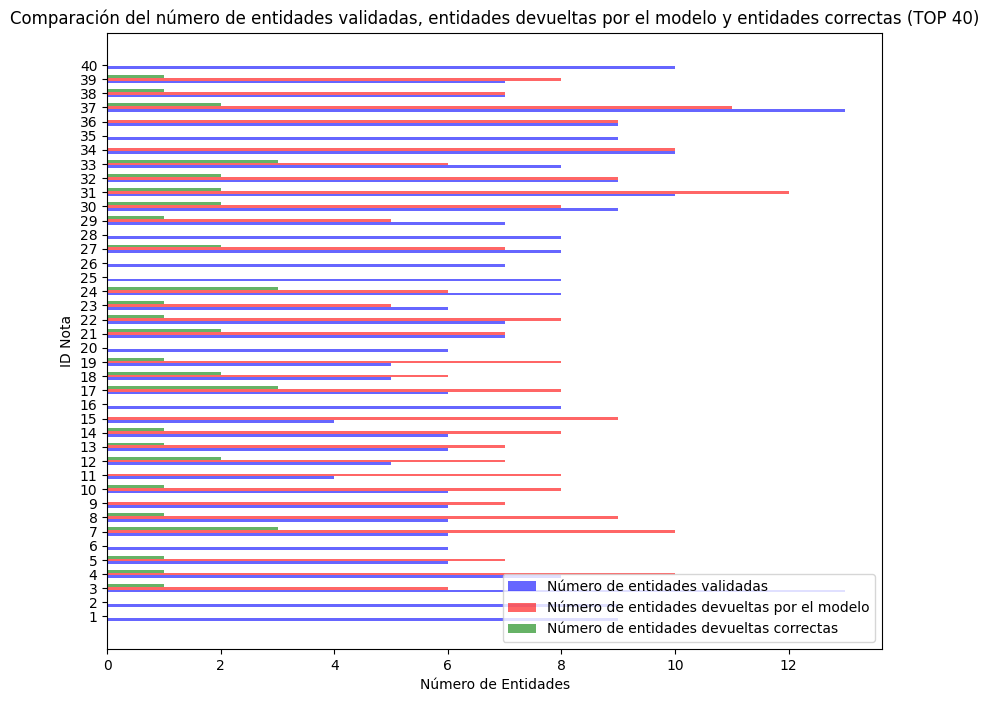

In [ ]:
import matplotlib.pyplot as plt

def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_raw_entities['num_matching_codes'] = combined_df_raw_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Tomar los primeros 40 registros del DataFrame original
top_40_df = combined_df_raw_entities.head(40)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = top_40_df['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, top_40_df['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='Número de entidades validadas')
bars2 = ax.barh(r2, top_40_df['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='Número de entidades devueltas por el modelo')
bars3 = ax.barh(r3, top_40_df['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='Número de entidades devueltas correctas')

# Añadir etiquetas y título
ax.set_ylabel('ID Nota')
ax.set_xlabel('Número de Entidades')
ax.set_title('Comparación del número de entidades validadas, entidades devueltas por el modelo y entidades correctas (TOP 40)')
ax.set_yticks(y)
ax.set_yticklabels(top_40_df['id_note'])
ax.legend()

# Mostrar el gráfico
plt.show()


## response_pe_csv (Mistral prompt engineering)

In [ ]:
combined_df_pe_entities = num_entities(val_data, response_pe_csv, combined_df_pe)
combined_df_pe_entities.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score,num_val_concepts,num_response_concepts
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{M62.81, J96.1, R42, R47.1, I95.1, R25.2, R06....",0.583333,0.777778,0.700000,0.736842,9,10.0
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{},0.000000,0.000000,0.000000,0.000000,9,0.0
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{R29.2, M62.81, R42, N39.4, R47.1, R25.2, R06.00}",0.176471,0.230769,0.428571,0.300000,13,7.0
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R42, R47.81, Z86.011, E11.9, R25.3, R...",0.062500,0.125000,0.111111,0.117647,8,9.0
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{F32.A, R47.1, R32, R25.2, R53.83, Z74.0, R06.00}",0.200000,0.400000,0.285714,0.333333,6,7.0


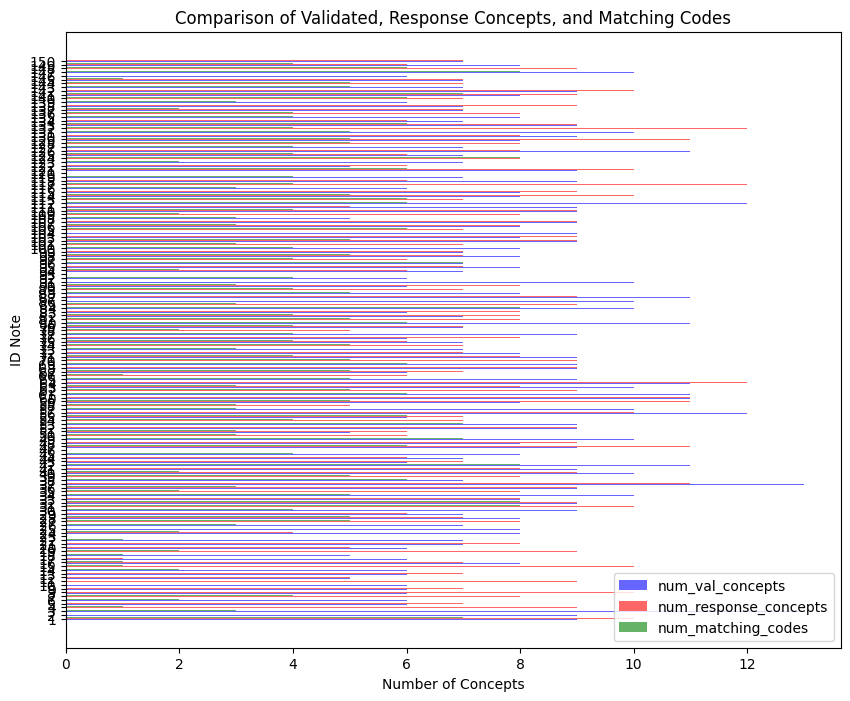

In [ ]:
import matplotlib.pyplot as plt
def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_pe_entities['num_matching_codes'] = combined_df_pe_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = combined_df_pe_entities['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, combined_df_pe_entities['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='num_val_concepts')
bars2 = ax.barh(r2, combined_df_pe_entities['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='num_response_concepts')
bars3 = ax.barh(r3, combined_df_pe_entities['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='num_matching_codes')

# Añadir etiquetas y título
ax.set_ylabel('ID Note')
ax.set_xlabel('Number of Concepts')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes')
ax.set_yticks(y)
ax.set_yticklabels(combined_df_pe_entities['id_note'])
ax.legend()

# Añadir los valores de 'evaluation_metric' al lado derecho de las barras
# for i, (r1_val, r2_val, r3_val, eval_metric) in enumerate(zip(r1, r2, r3, combined_df['evaluation_metric'])):
#     ax.text(combined_df['num_response_concepts'][i] + 0.1, r2_val, f'{eval_metric:.2f}', va='center')

# Mostrar el gráfico
plt.show()

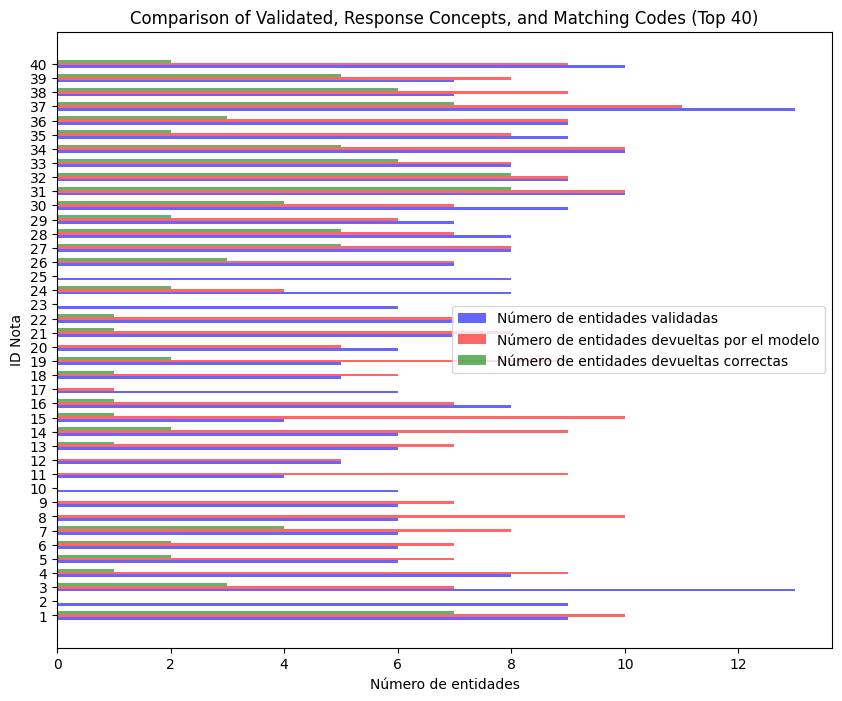

In [ ]:
import matplotlib.pyplot as plt

def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_pe_entities['num_matching_codes'] = combined_df_pe_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Tomar los primeros 40 registros del DataFrame original
top_40_df = combined_df_pe_entities.head(40)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = top_40_df['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, top_40_df['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='Número de entidades validadas')
bars2 = ax.barh(r2, top_40_df['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='Número de entidades devueltas por el modelo')
bars3 = ax.barh(r3, top_40_df['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='Número de entidades devueltas correctas')

# Añadir etiquetas y título
ax.set_ylabel('ID Nota')
ax.set_xlabel('Número de entidades')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes (Top 40)')
ax.set_yticks(y)
ax.set_yticklabels(top_40_df['id_note'])
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
combined_df_pe_entities['difference'] = (combined_df_pe_entities['num_val_concepts'] - combined_df_pe_entities['num_response_concepts']).abs()

# Calcular la media de estas diferencias
mean_difference_pe = combined_df_pe_entities['difference'].mean()

print("La diferencia media es:", round(mean_difference_pe))

La diferencia media es: 2


## response_RAG_csv (Mistral RAG ClinicalBERT)

In [ ]:
combined_df_CBRAG_entities = num_entities(val_data, response_CBRAG_csv, combined_df_CBRAG)
combined_df_CBRAG_entities.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score,num_val_concepts,num_response_concepts
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{M62.81, R47.1, J47.3, F41.1, J46.0, G26.1, Z9...",0.117647,0.222222,0.200,0.210526,9,10.0
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{},0.000000,0.000000,0.000,0.000000,9,0.0
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{M62.81, R47.1, R35.0, J47.3, R54.1}",0.058824,0.076923,0.200,0.111111,13,6.0
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, F41.1, R4...",0.066667,0.125000,0.125,0.125000,8,8.0
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}",{},0.000000,0.000000,0.000,0.000000,6,0.0


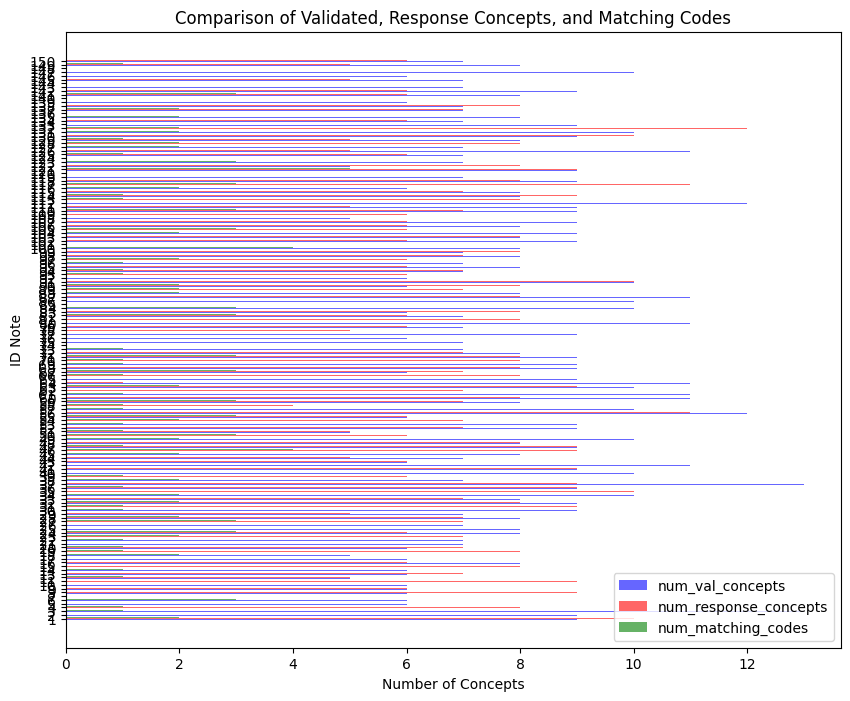

In [ ]:
import matplotlib.pyplot as plt
def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_CBRAG_entities['num_matching_codes'] = combined_df_CBRAG_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = combined_df_CBRAG_entities['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, combined_df_CBRAG_entities['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='num_val_concepts')
bars2 = ax.barh(r2, combined_df_CBRAG_entities['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='num_response_concepts')
bars3 = ax.barh(r3, combined_df_CBRAG_entities['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='num_matching_codes')

# Añadir etiquetas y título
ax.set_ylabel('ID Note')
ax.set_xlabel('Number of Concepts')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes')
ax.set_yticks(y)
ax.set_yticklabels(combined_df_CBRAG_entities['id_note'])
ax.legend()

# Añadir los valores de 'evaluation_metric' al lado derecho de las barras
# for i, (r1_val, r2_val, r3_val, eval_metric) in enumerate(zip(r1, r2, r3, combined_df['evaluation_metric'])):
#     ax.text(combined_df['num_response_concepts'][i] + 0.1, r2_val, f'{eval_metric:.2f}', va='center')

# Mostrar el gráfico
plt.show()

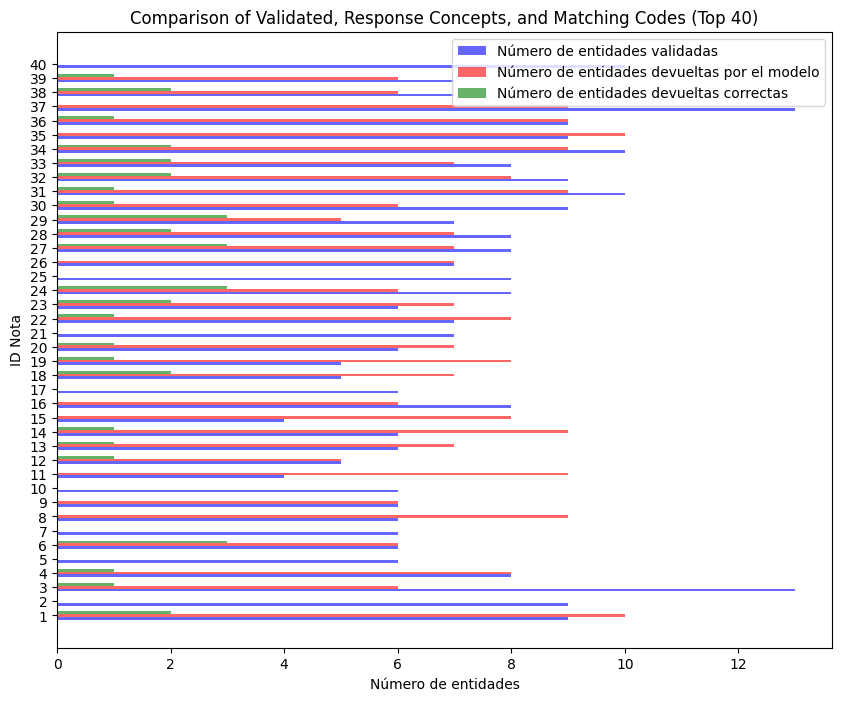

In [ ]:
import matplotlib.pyplot as plt

def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_CBRAG_entities['num_matching_codes'] = combined_df_CBRAG_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Tomar los primeros 40 registros del DataFrame original
top_40_df = combined_df_CBRAG_entities.head(40)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = top_40_df['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, top_40_df['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='Número de entidades validadas')
bars2 = ax.barh(r2, top_40_df['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='Número de entidades devueltas por el modelo')
bars3 = ax.barh(r3, top_40_df['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='Número de entidades devueltas correctas')

# Añadir etiquetas y título
ax.set_ylabel('ID Nota')
ax.set_xlabel('Número de entidades')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes (Top 40)')
ax.set_yticks(y)
ax.set_yticklabels(top_40_df['id_note'])
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
combined_df_CBRAG_entities['difference'] = (combined_df_CBRAG_entities['num_val_concepts'] - combined_df_CBRAG_entities['num_response_concepts']).abs()

# Calcular la media de estas diferencias
mean_difference_CBRAG = combined_df_CBRAG_entities['difference'].mean()

print("La diferencia media es:", round(mean_difference_CBRAG))

La diferencia media es: 3


## response_BioRAG_csv (Mistral RAG BioBERT)

In [ ]:
combined_df_BioRAG_entities = num_entities(val_data, response_BioRAG_csv, combined_df_BioRAG)
combined_df_BioRAG_entities.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score,num_val_concepts,num_response_concepts
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....","{G25.1, M62.81, R47.1, J47.3, J46.0, F41.1, Z9...",0.117647,0.222222,0.200000,0.210526,9,10.0
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....",{},0.000000,0.000000,0.000000,0.000000,9,0.0
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.1}",0.055556,0.076923,0.166667,0.105263,13,7.0
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R29.20, R47.1, R13.1, G11.2, R26.3, Z...",0.066667,0.125000,0.125000,0.125000,8,8.0
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}","{R47.1, M62.81, G83.1, R25.2, R53.83, F32.0, R...",0.083333,0.200000,0.125000,0.153846,6,8.0


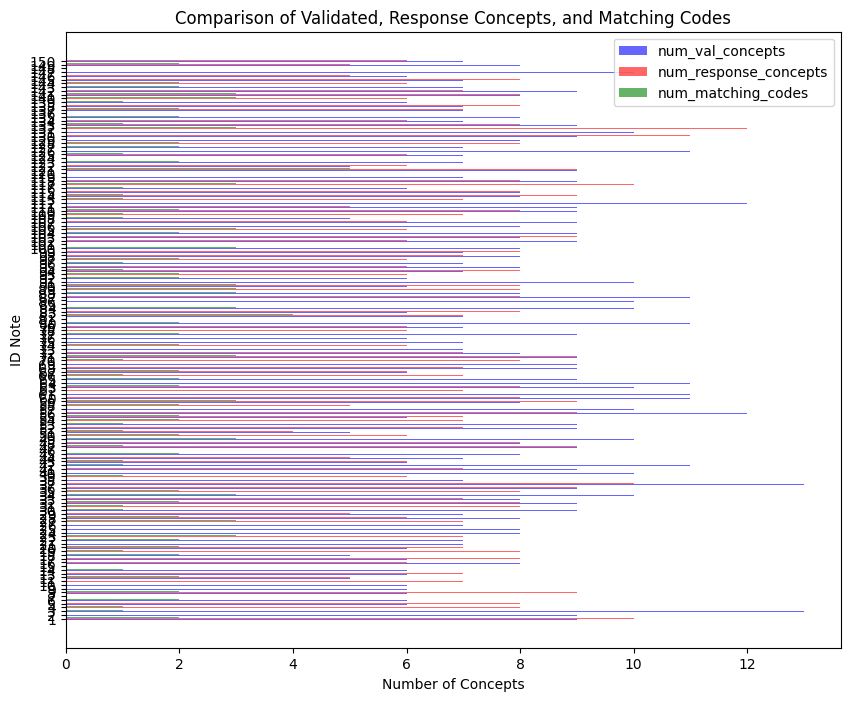

In [ ]:
import matplotlib.pyplot as plt
def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_BioRAG_entities['num_matching_codes'] = combined_df_BioRAG_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = combined_df_BioRAG_entities['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, combined_df_BioRAG_entities['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='num_val_concepts')
bars2 = ax.barh(r2, combined_df_BioRAG_entities['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='num_response_concepts')
bars3 = ax.barh(r3, combined_df_BioRAG_entities['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='num_matching_codes')

# Añadir etiquetas y título
ax.set_ylabel('ID Note')
ax.set_xlabel('Number of Concepts')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes')
ax.set_yticks(y)
ax.set_yticklabels(combined_df_BioRAG_entities['id_note'])
ax.legend()

# Añadir los valores de 'evaluation_metric' al lado derecho de las barras
# for i, (r1_val, r2_val, r3_val, eval_metric) in enumerate(zip(r1, r2, r3, combined_df['evaluation_metric'])):
#     ax.text(combined_df['num_response_concepts'][i] + 0.1, r2_val, f'{eval_metric:.2f}', va='center')

# Mostrar el gráfico
plt.show()

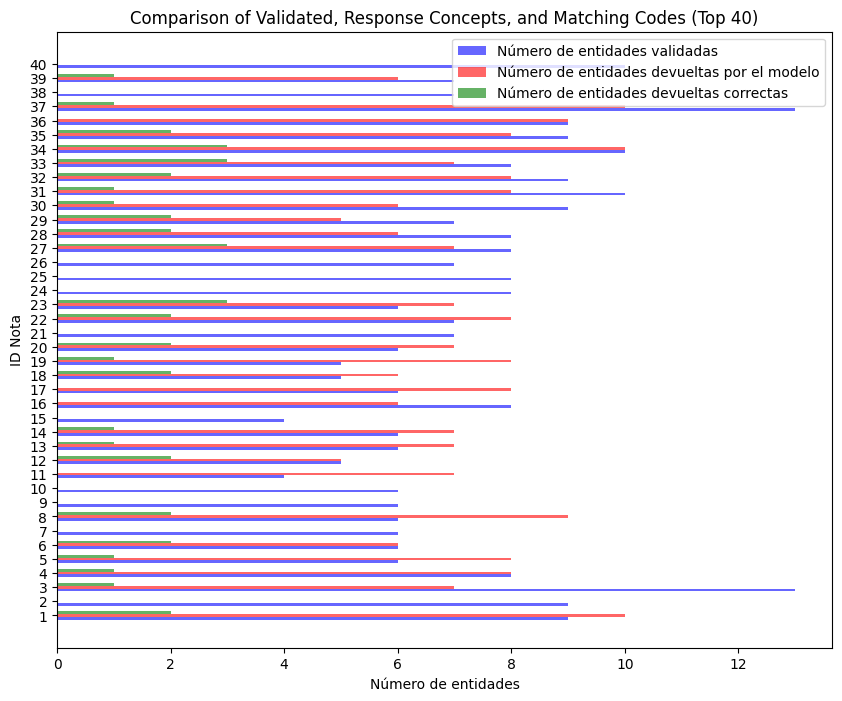

In [ ]:
import matplotlib.pyplot as plt

def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_BioRAG_entities['num_matching_codes'] = combined_df_BioRAG_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Tomar los primeros 40 registros del DataFrame original
top_40_df = combined_df_BioRAG_entities.head(40)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = top_40_df['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, top_40_df['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='Número de entidades validadas')
bars2 = ax.barh(r2, top_40_df['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='Número de entidades devueltas por el modelo')
bars3 = ax.barh(r3, top_40_df['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='Número de entidades devueltas correctas')

# Añadir etiquetas y título
ax.set_ylabel('ID Nota')
ax.set_xlabel('Número de entidades')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes (Top 40)')
ax.set_yticks(y)
ax.set_yticklabels(top_40_df['id_note'])
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
combined_df_BioRAG_entities['difference'] = (combined_df_BioRAG_entities['num_val_concepts'] - combined_df_BioRAG_entities['num_response_concepts']).abs()

# Calcular la media de estas diferencias
mean_difference_BioRAG = combined_df_BioRAG_entities['difference'].mean()

print("La diferencia media es:", round(mean_difference_BioRAG))

La diferencia media es: 3


## response_BERTRAG_csv (Mistral RAG BERT)

In [ ]:
combined_df_BERTRAG_entities = num_entities(val_data, response_BERTRAG_csv, combined_df_BERTRAG)
combined_df_BERTRAG_entities.head()

,id_note,note,val_icd10,response_icd10,accuracy,recall,precision,f1_score,num_val_concepts,num_response_concepts
0,1,Pt reports ongoing difficulty in breathing and...,"{M62.81, J96.1, R42, R47.1, I95.1, F41.0, R25....",{},0.000000,0.000000,0.000000,0.000000,9,0.0
1,2,Patient reports experiencing significant diffi...,"{J96.1, F41.9, F32, R07.1, R25.3, R47.82, Z74....","{F32.9, R27.0, G26.3, R47.1, J47.0}",0.000000,0.000000,0.000000,0.000000,9,5.0
2,3,Pt. reports persistent muscl weakness and has ...,"{M62.81, R42, F41.9, R06.0, I95.1, Z99.3, R29....","{, M62.81, R47.1, R35.0, J47.3, R54.9}",0.055556,0.076923,0.166667,0.105263,13,6.0
3,4,Patient is experiencing persistent muscle weak...,"{M62.81, J96.1, N39.46, I95.1, Z99.3, R47.82, ...","{M62.81, R47.1, R13.1, G11.2, R26.3, Z92.2, R4...",0.066667,0.125000,0.125000,0.125000,8,8.0
4,5,Pt. has reported severe muscle cramps and spas...,"{M62.81, R32, R25.3, R53.83, R26.0}",{},0.000000,0.000000,0.000000,0.000000,6,0.0


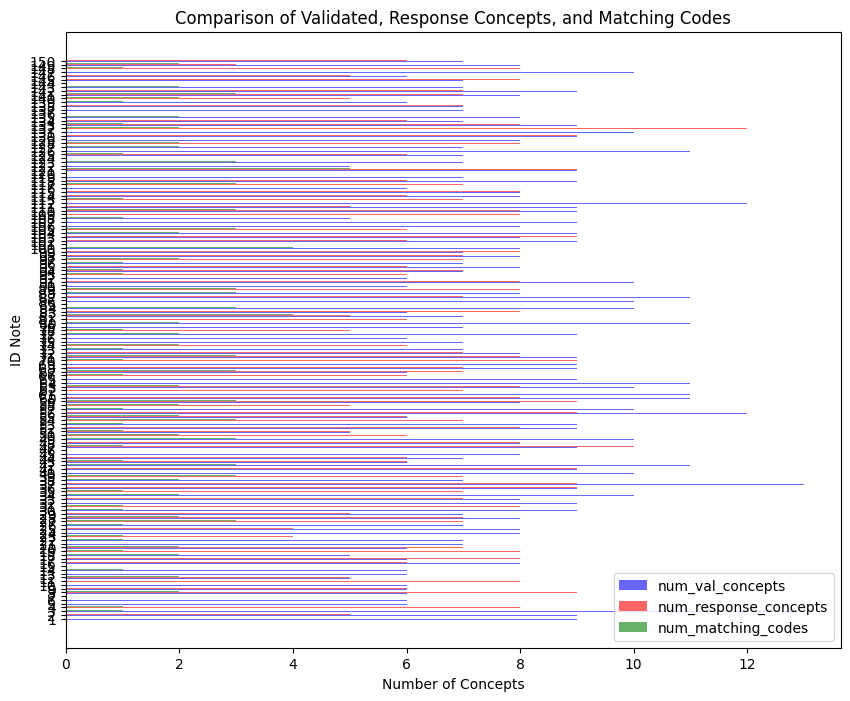

In [ ]:
import matplotlib.pyplot as plt
def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_BERTRAG_entities['num_matching_codes'] = combined_df_BERTRAG_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = combined_df_BERTRAG_entities['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, combined_df_BERTRAG_entities['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='num_val_concepts')
bars2 = ax.barh(r2, combined_df_BERTRAG_entities['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='num_response_concepts')
bars3 = ax.barh(r3, combined_df_BERTRAG_entities['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='num_matching_codes')

# Añadir etiquetas y título
ax.set_ylabel('ID Note')
ax.set_xlabel('Number of Concepts')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes')
ax.set_yticks(y)
ax.set_yticklabels(combined_df_BERTRAG_entities['id_note'])
ax.legend()

# Añadir los valores de 'evaluation_metric' al lado derecho de las barras
# for i, (r1_val, r2_val, r3_val, eval_metric) in enumerate(zip(r1, r2, r3, combined_df['evaluation_metric'])):
#     ax.text(combined_df['num_response_concepts'][i] + 0.1, r2_val, f'{eval_metric:.2f}', va='center')

# Mostrar el gráfico
plt.show()

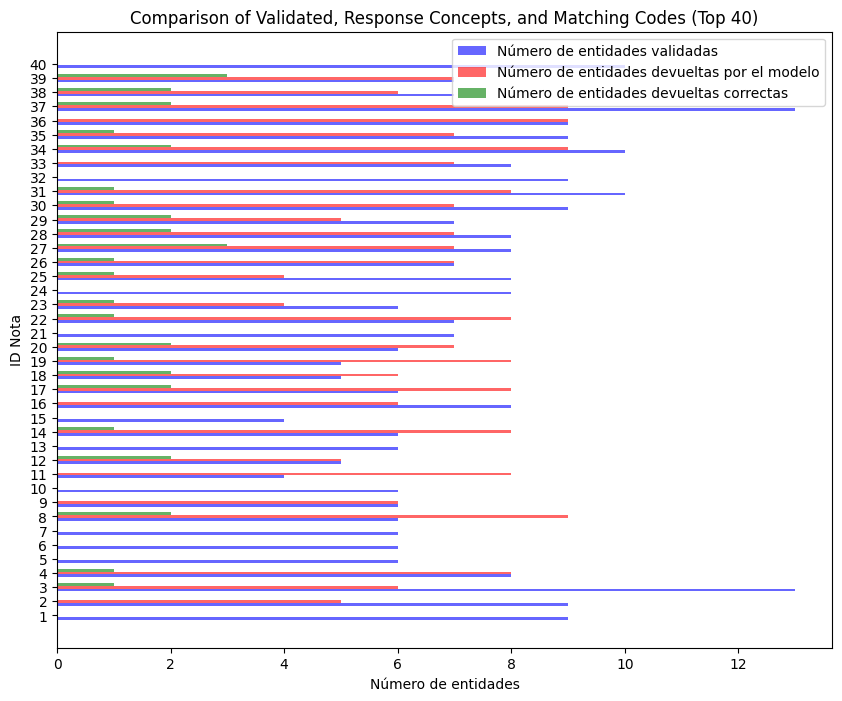

In [ ]:
import matplotlib.pyplot as plt

def count_matching_codes(val_icd10, response_icd10):
    return len(set(val_icd10).intersection(set(response_icd10)))

# Añadir la columna 'num_matching_codes' al DataFrame
combined_df_BERTRAG_entities['num_matching_codes'] = combined_df_BERTRAG_entities.apply(lambda row: count_matching_codes(row['val_icd10'], row['response_icd10']), axis=1)

# Tomar los primeros 40 registros del DataFrame original
top_40_df = combined_df_BERTRAG_entities.head(40)

# Crear el gráfico de barras horizontales superpuestas
fig, ax = plt.subplots(figsize=(10, 8))

# Valores de y
y = top_40_df['id_note']

# Ancho de las barras
bar_height = 0.2

# Posiciones de las barras
r1 = y - bar_height
r2 = y
r3 = y + bar_height

# Crear las barras horizontales
bars1 = ax.barh(r1, top_40_df['num_val_concepts'], color='b', height=bar_height, alpha=0.6, label='Número de entidades validadas')
bars2 = ax.barh(r2, top_40_df['num_response_concepts'], color='r', height=bar_height, alpha=0.6, label='Número de entidades devueltas por el modelo')
bars3 = ax.barh(r3, top_40_df['num_matching_codes'], color='g', height=bar_height, alpha=0.6, label='Número de entidades devueltas correctas')

# Añadir etiquetas y título
ax.set_ylabel('ID Nota')
ax.set_xlabel('Número de entidades')
ax.set_title('Comparison of Validated, Response Concepts, and Matching Codes (Top 40)')
ax.set_yticks(y)
ax.set_yticklabels(top_40_df['id_note'])
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
combined_df_BERTRAG_entities['difference'] = (combined_df_BERTRAG_entities['num_val_concepts'] - combined_df_BERTRAG_entities['num_response_concepts']).abs()

# Calcular la media de estas diferencias
mean_difference_BERTRAG = combined_df_BioRAG_entities['difference'].mean()

print("La diferencia media es:", round(mean_difference_BioRAG))

La diferencia media es: 3


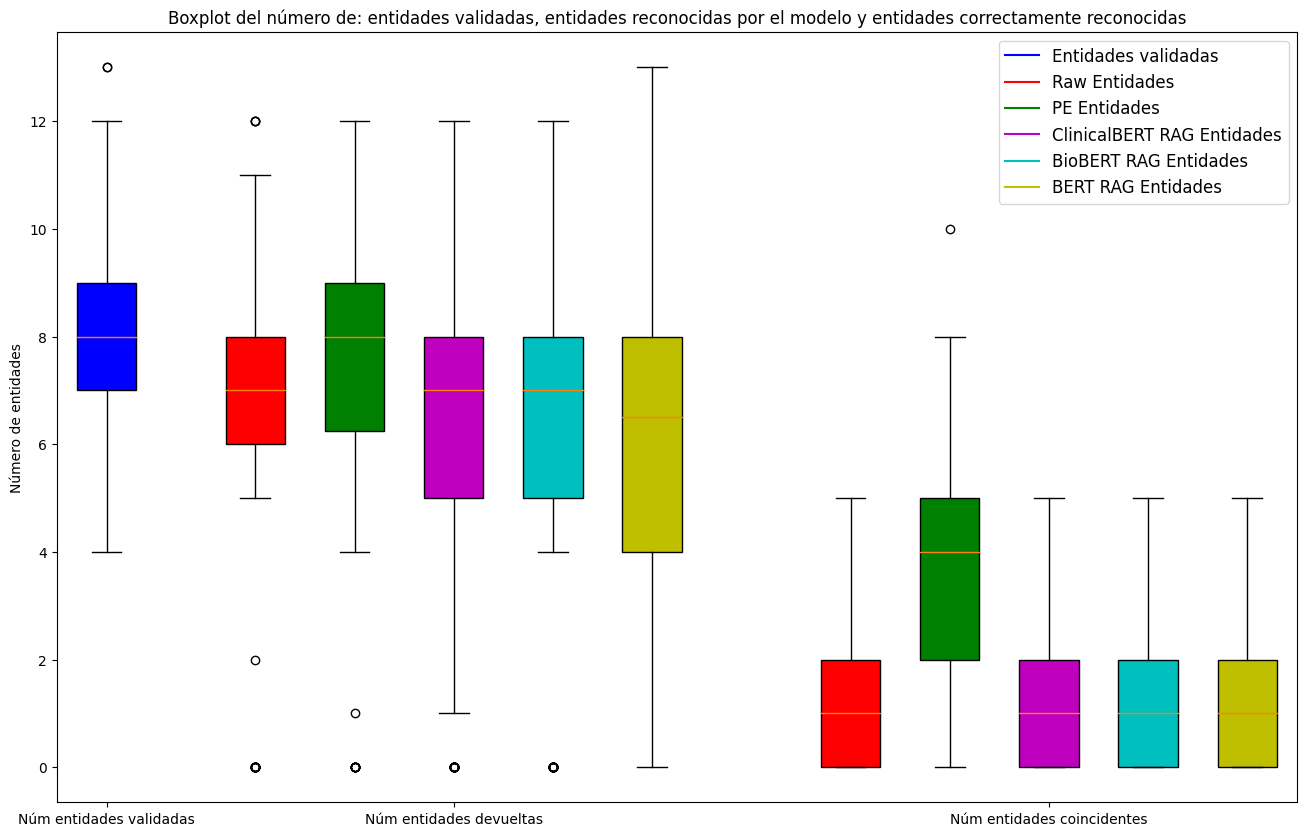

In [ ]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(16, 10))

# Configurar colores para cada dataframe
colors = ['r', 'g', 'm', 'c', 'y']

# Datos y etiquetas para los boxplots
data_labels = ['Núm entidades validadas', 'Núm entidades devueltas', 'Núm entidades coincidentes']
dataframes = [
    combined_df_raw_entities,
    combined_df_pe_entities,
    combined_df_CBRAG_entities,
    combined_df_BioRAG_entities,
    combined_df_BERTRAG_entities
]
df_labels = ['Raw Entidades', 'PE Entidades', 'ClinicalBERT RAG Entidades', 'BioBERT RAG Entidades', 'BERT RAG Entidades']

# Crear el boxplot de num_val_concepts como referencia
ref_data = combined_df_raw_entities['num_val_concepts']
ref_positions = [2.5]  # Posición del boxplot de referencia (centrada)

bp_ref = ax.boxplot([ref_data], positions=ref_positions, patch_artist=True, widths=0.6)

# Colorear el boxplot de referencia
for patch in bp_ref['boxes']:
    patch.set_facecolor('b')

# Añadir leyenda para el boxplot de referencia
ax.plot([], c='b', label='Entidades validadas')

# Recorrer cada dataframe y crear un conjunto de boxplots para num_response_concepts y num_matching_codes
for i, df in enumerate(dataframes):
    data = [df['num_response_concepts'], df['num_matching_codes']]
    positions = [j*6 + i + 4 for j in range(len(data))]  # Posiciones para los boxplots, dejando espacio

    bp = ax.boxplot(data, positions=positions, patch_artist=True, widths=0.6)

    # Colorear los boxplots
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i])

    # Añadir leyenda para el primer boxplot de cada dataframe
    ax.plot([], c=colors[i], label=df_labels[i])

# Configurar el eje x
# Ajustar las posiciones de los ticks para centrar las etiquetas
xticks = [2.5] + [i*6 + 6 for i in range(len(data_labels)-1)]
ax.set_xticks(xticks)
ax.set_xticklabels(['Núm entidades validadas'] + data_labels[1:])

# Añadir etiquetas y título
ax.set_ylabel('Número de entidades')
ax.set_title('Boxplot del número de: entidades validadas, entidades reconocidas por el modelo y entidades correctamente reconocidas')

# Añadir leyenda con tamaño de fuente más grande
ax.legend(fontsize=12)

# Mostrar el gráfico
plt.show()



# Comparación directa de entidades

In [ ]:
print(val_data['Note'][val_data['id_note']==1][0])

print(response_csv[['Concept', 'ICD10']][response_csv['id_note'] == 1])

print(val_data[['Concept', 'ICD10']][val_data['id_note'] == 1])



Pt reports ongoing difficulty in breathing and shortness of breath during physical activities. There's been a notable increase in muscle weakness, especially in the limbs. Also complains of frequent spasms and involuntary movements. During the examination, dysarthria was observed, affecting pt's ability to communicate clearly. Pt also mentioned episodes of dizziness and orthostatic hypotension. Additionally, the pt has experienced chronic respiratory failure and requires assistance for mobility. Pt's emotional state is impacted, with signs of anxiety and panic attacks.
Empty DataFrame
Columns: [Concept, ICD10]
Index: []
                                           Concept   ICD10
0  difficulty in breathing and shortness of breath  R06.02
1                      chronic respiratory failure   J96.1
2                                       dysarthria   R47.1
3                        anxiety and panic attacks   F41.0
4                                        dizziness     R42
5                 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Especifica el nombre del archivo HTML que descargaste
html_filename = 'Evaluacion_modelos_v2_NTT_synthetic_data_150.html'

# Mueve el archivo HTML a tu Google Drive
!mv {html_filename} /content/drive/MyDrive/Data/Resultados_Metricas/htmls/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mv: cannot stat 'Evaluacion_modelos_v2_NTT_synthetic_data_150.html': No such file or directory
